In [ ]:
combine = pd.read_excel("Visitation_1.xlsx", sheet_name="Combine Visit + Climate") # Preview combine.head()

In [ ]:
import pandas as pd

In [ ]:
combine.rename(columns={
    "Average of Minimum temperature (Degree C)": "MinTemp_C",
    "Average of Maximum temperature (Degree C)": "MaxTemp_C",
    "Average of Rainfall amount (millimetres)": "Rain_mm",
    "Sum of Mt. Buller": "Mt. Buller",
    "Sum of Falls Creek": "Falls Creek",
    "Sum of Mt. Hotham": "Mt. Hotham",
    "Sum of Mt. Stirling": "Mt. Stirling",
    "Sum of Mt. Baw Baw": "Mt. Baw Baw",
    "Sum of Selwyn": "Selwyn",
    "Sum of Thredbo": "Thredbo",
    "Sum of Perisher": "Perisher",
    "Sum of Charlotte Pass": "Charlotte Pass"

}, inplace=True)

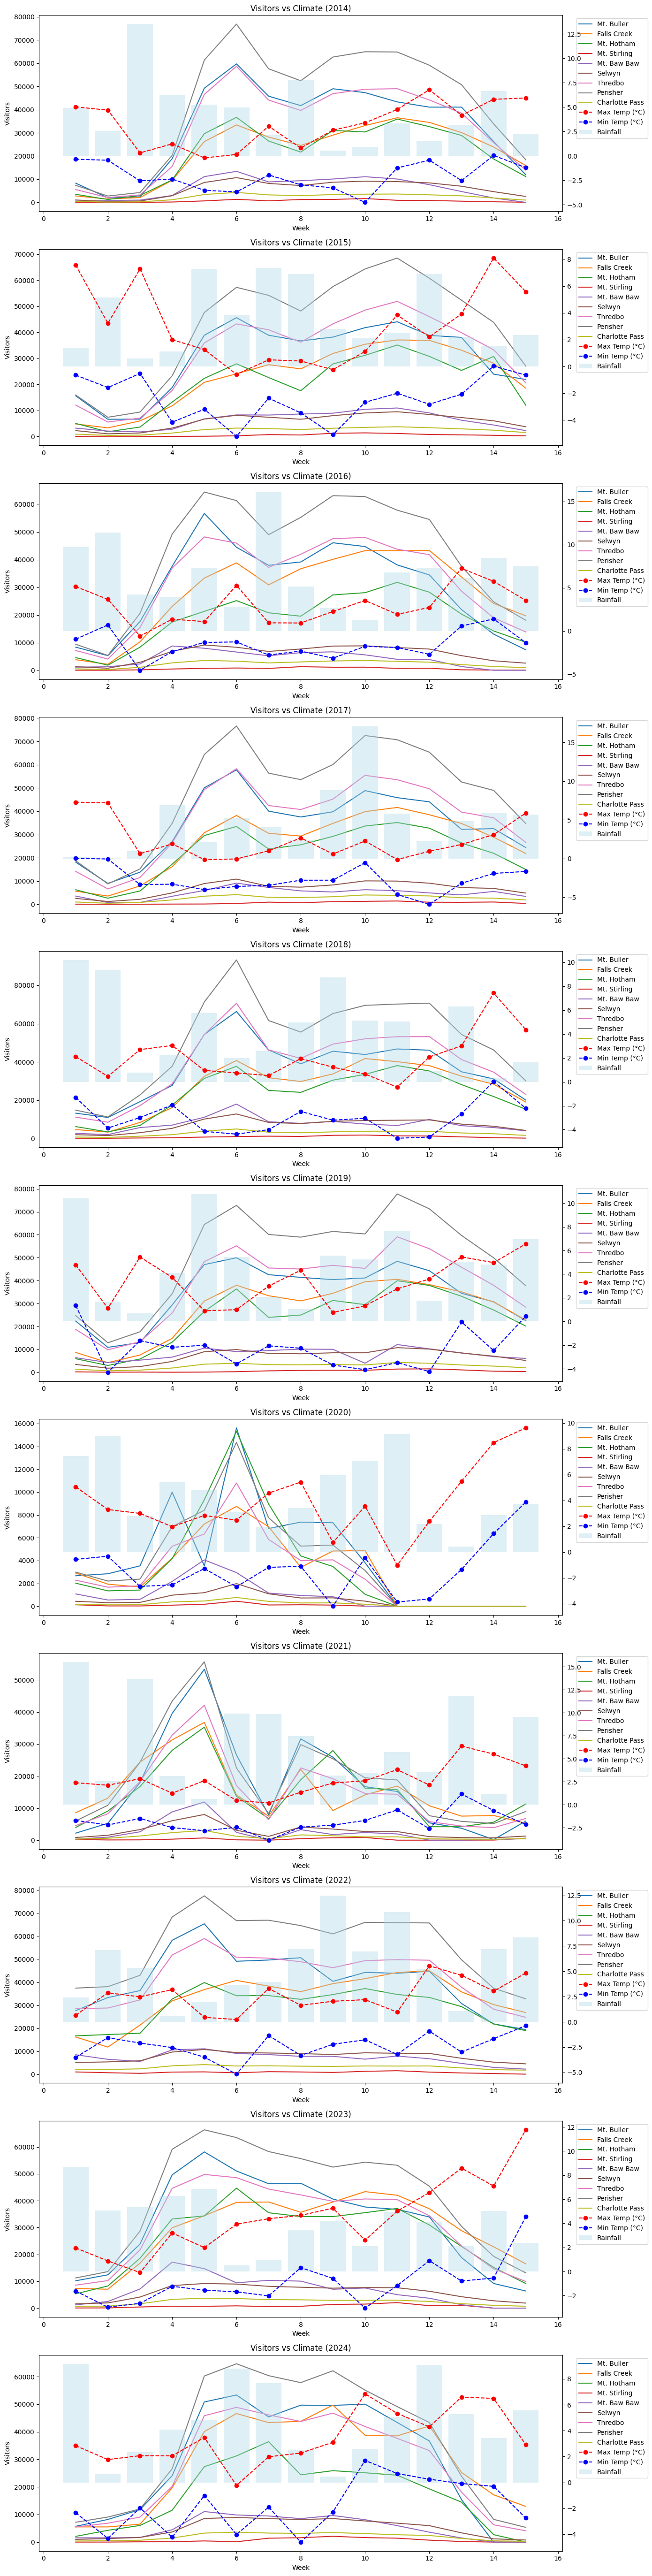

In [ ]:
import matplotlib.pyplot as plt

# --- resort columns (everything except Year/Week/climate) ---
resort_cols = [c for c in combine.columns
               if c not in ["Year","Week","MinTemp_C","MaxTemp_C","Rain_mm","Visitors_Total"]]

years = combine["Year"].unique()

fig, axes = plt.subplots(len(years), 1, figsize=(14, 5*len(years)), sharex=False)

if len(years) == 1:
    axes = [axes]  # make iterable if only one year

for ax, year_sel in zip(axes, years):
    df_year = combine[combine["Year"]==year_sel]

    # --- Visitors (Resorts) ---
    for c in resort_cols:
        ax.plot(df_year["Week"], df_year[c], label=c, linewidth=1.5)

    ax.set_title(f"Visitors vs Climate ({year_sel})")
    ax.set_xlabel("Week")
    ax.set_ylabel("Visitors")

    # --- Secondary axis for climate ---
    ax2 = ax.twinx()
    ax2.plot(df_year["Week"], df_year["MaxTemp_C"], color="red", linestyle="--", marker="o", label="Max Temp (°C)")
    ax2.plot(df_year["Week"], df_year["MinTemp_C"], color="blue", linestyle="--", marker="o", label="Min Temp (°C)")
    ax2.bar(df_year["Week"], df_year["Rain_mm"], alpha=0.4, color="lightblue", label="Rainfall")  # darker blue    ax2.set_ylabel("Temp (°C) / Rain (mm)")

    # --- Legends merged ---
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left", bbox_to_anchor=(1.02,1))

plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- inputs ----------
df = combine.copy()                     # your combined table
out_dir = "yearly_charts"               # folder to save separate charts
os.makedirs(out_dir, exist_ok=True)

# columns that are NOT resorts (adjust if your names differ)
non_resort = {
    "Year","Week","MinTemp_C","MaxTemp_C","Rain_mm","Visitors_Total",
    "Average of Minimum temperature (Degree C)",
    "Average of Maximum temperature (Degree C)",
    "Average of Rainfall amount (millimetres)"
}

# try to normalize climate column names if pivot labels are still long
rename_map = {
    "Average of Minimum temperature (Degree C)": "MinTemp_C",
    "Average of Maximum temperature (Degree C)": "MaxTemp_C",
    "Average of Rainfall amount (millimetres)":  "Rain_mm",
}
df = df.rename(columns=rename_map)

# identify resort columns = numeric columns not in non_resort
resort_cols = [c for c in df.columns
               if c not in non_resort and np.issubdtype(df[c].dtype, np.number)]

# trendy cool palette
palette = ["#0EA5E9","#38BDF8","#60A5FA","#818CF8","#A78BFA","#C084FC","#E879F9"]
color_map = {r: palette[i % len(palette)] for i, r in enumerate(resort_cols)}

def comma(x, _): return f"{int(x):,}"

# optional: holiday bands per AU winter (tweak to your calendars)
holiday_bands = [(6,8), (10,11)]   # weeks inclusive

for yr in sorted(df["Year"].unique()):
    d = df[df["Year"] == yr].sort_values("Week").copy()
    if d.empty:
        continue

    # totals per week
    d["TotalVisitors"] = d[resort_cols].sum(axis=1)

    fig, ax = plt.subplots(figsize=(14, 5))

    # --- stacked visitors (left axis) ---
    stacks = [d[c].values for c in resort_cols]
    ax.stackplot(
        d["Week"], stacks,
        labels=resort_cols,
        colors=[color_map[c] for c in resort_cols],
        alpha=0.88
    )
    ax.set_ylabel("Visitors")
    ax.yaxis.set_major_formatter(FuncFormatter(comma))
    ax.grid(axis="y", alpha=0.25, linestyle="--", linewidth=0.6)

    # --- climate (right axis) ---
    ax2 = ax.twinx()
    # darker blue rain bars
    ax2.bar(d["Week"], d["Rain_mm"], color="#0B3C5D", alpha=0.45, width=0.65, label="Rain (mm)")
    # smoothed max temp line
    temp_sm = d["MaxTemp_C"].rolling(3, center=True, min_periods=1).mean()
    ax2.plot(d["Week"], temp_sm, color="#EF4444", linewidth=2.3, label="Max Temp (°C)")
    ax2.set_ylabel("Temp (°C) / Rain (mm)")

    # --- highlight school holidays ---
    for w0, w1 in holiday_bands:
        ax.axvspan(w0-0.5, w1+0.5, color="#FACC15", alpha=0.14, lw=0)

    # --- annotate peak week ---
    wk_peak = int(d.loc[d["TotalVisitors"].idxmax(), "Week"])
    val_peak = int(d["TotalVisitors"].max())
    ax.annotate(
        f"Peak W{wk_peak}: {val_peak:,}",
        xy=(wk_peak, val_peak),
        xytext=(wk_peak+0.2, val_peak*1.06),
        fontsize=6, color="#374151",
        arrowprops=dict(arrowstyle="-", lw=0.9, color="#6B7280")
    )

    # axis cosmetics
    ax.set_xlim(1, 15)
    ax.set_xticks(range(1, 16))
    ax.set_xlabel("Week of Season")
    ax.set_title(f"Visitors vs Climate — {yr}", loc="left", fontsize=13, weight="bold")

    # single legend (resorts + climate)
    resort_handles = [plt.Line2D([], [], color=color_map[r], lw=6) for r in resort_cols]
    climate_handles = [
        plt.Rectangle((0,0),1,1,color="#0B3C5D", alpha=0.45),
        plt.Line2D([], [], color="#EF4444", lw=2.3),
        plt.Rectangle((0,0),1,1,color="#FACC15", alpha=0.14)
    ]
    labels = resort_cols + ["Rain (mm)", "Max Temp (°C)", "School Holidays"]
    handles = resort_handles + climate_handles
    leg = fig.legend(handles, labels, ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False)
    for t in leg.get_texts(): t.set_fontsize(9)

    plt.tight_layout(rect=(0,0,1,0.98))
    out_path = os.path.join(out_dir, f"visitors_vs_climate_{yr}.png")
    plt.savefig(out_path, dpi=200)
    plt.close(fig)

print(f"Done! One PNG per year in: {os.path.abspath(out_dir)}")


Done! One PNG per year in: /content/yearly_charts


In [ ]:
visit = pd.read_excel("Visitation_1.xlsx", sheet_name="Visitation") # Preview combine.head()

In [ ]:
visit.head()

Year  Week  Mt. Baw Baw  Mt. Stirling  Mt. Hotham  Falls Creek  Mt. Buller  \
0  2014     1          555            60        3483         2790        8296   
1  2014     2          804            42        1253         1425        1987   
2  2014     3          993            30        2992         2101        2413   
3  2014     4         2976           165        9680         9544       18831   
4  2014     5        11112           645       29628        26211       49217   

   Selwyn  Thredbo  Perisher  Charlotte Pass  
0    1041     5535      7370             408  
1     383     2090      2751             151  
2     597     3216      4255             230  
3    2877    15497     20265            1134  
4    8588    46546     61339            3403

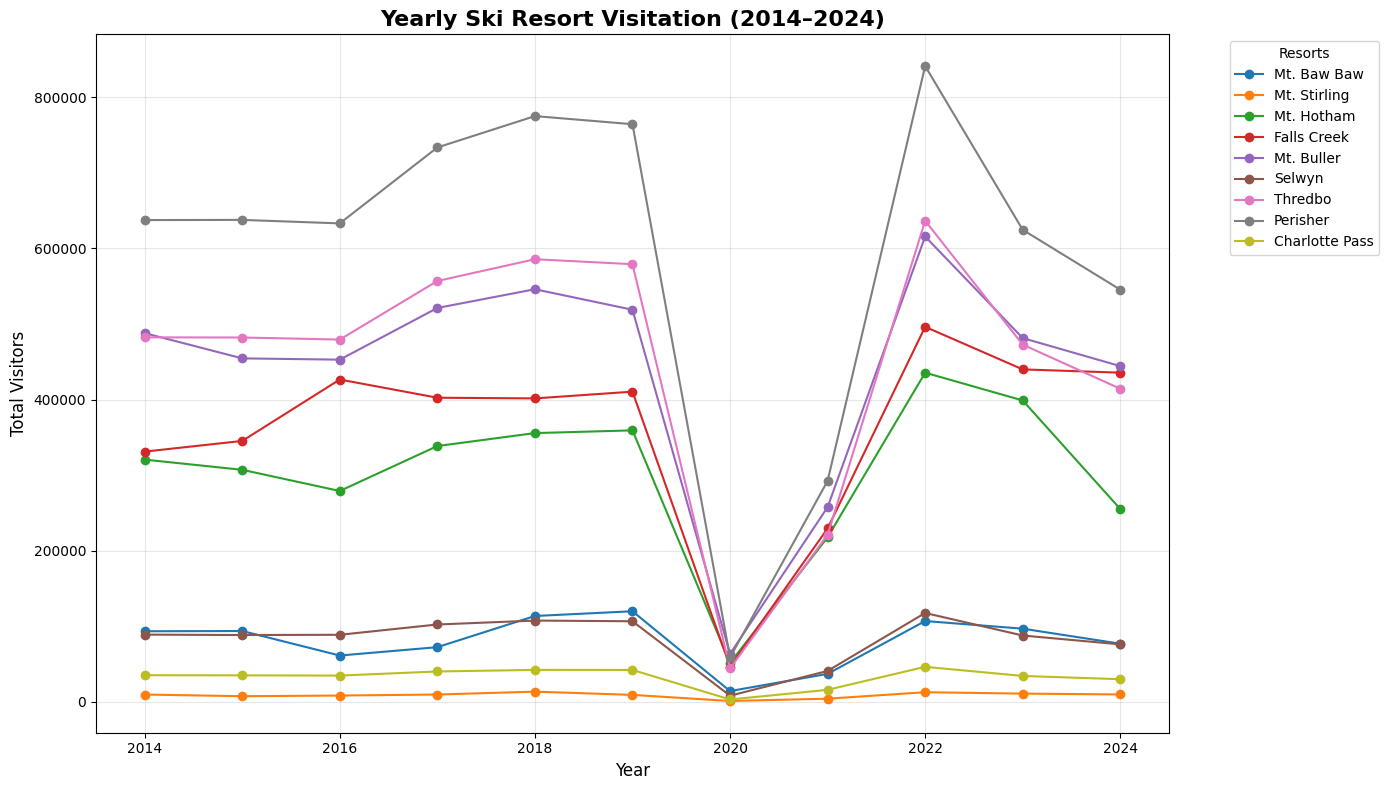

In [ ]:
resorts = ["Mt. Baw Baw", "Mt. Stirling", "Mt. Hotham", "Falls Creek",
           "Mt. Buller", "Selwyn", "Thredbo", "Perisher", "Charlotte Pass"]

visit[resorts] = visit[resorts].apply(pd.to_numeric, errors="coerce")

# Group by year and sum up visits
yearly_visits = visit.groupby("Year")[resorts].sum().reset_index()

# Plot
plt.figure(figsize=(14, 8))

for resort in resorts:
    plt.plot(yearly_visits["Year"], yearly_visits[resort], marker="o", label=resort)

plt.title("Yearly Ski Resort Visitation (2014–2024)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Visitors", fontsize=12)
plt.legend(title="Resorts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

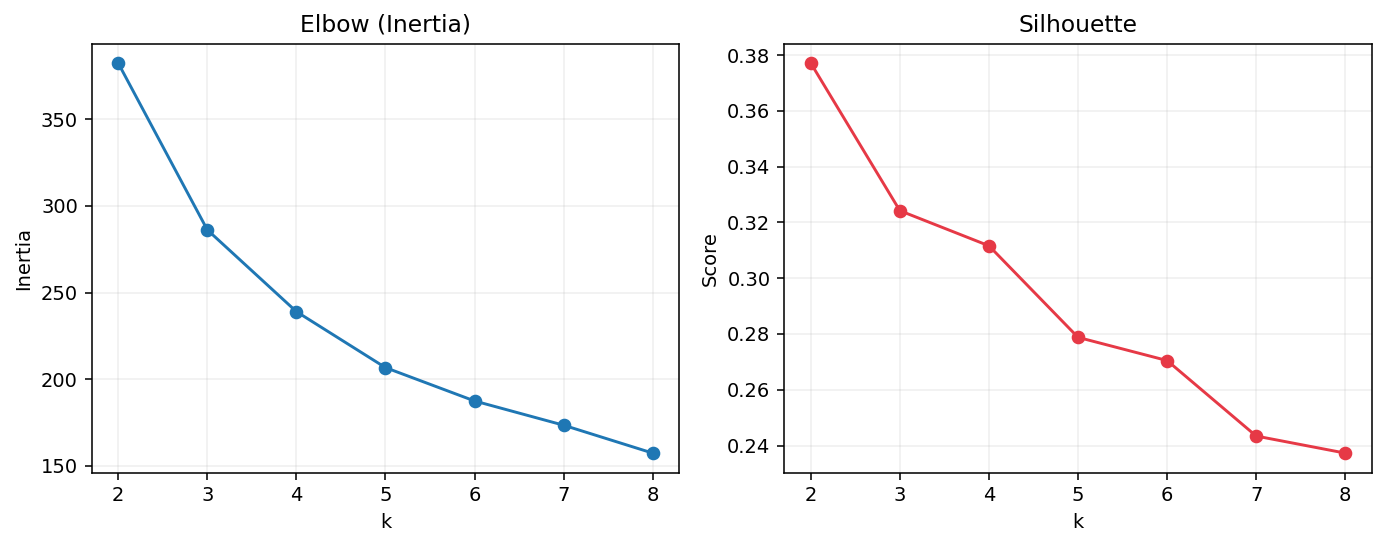

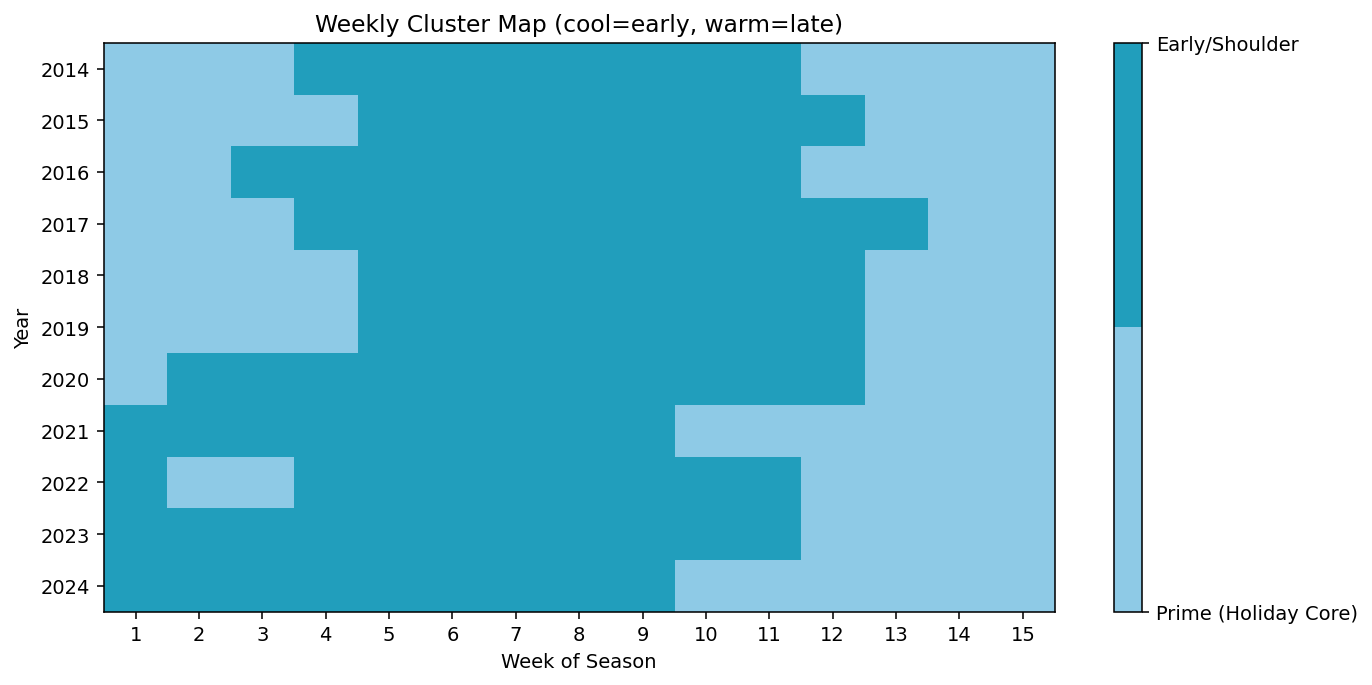

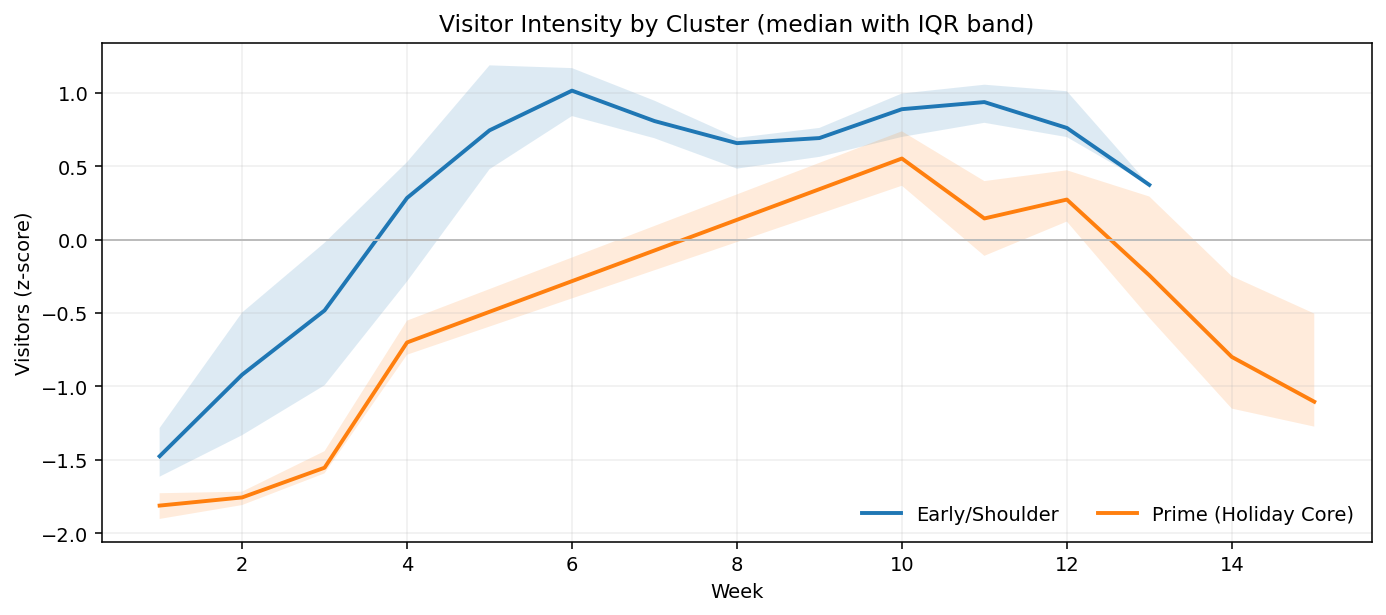

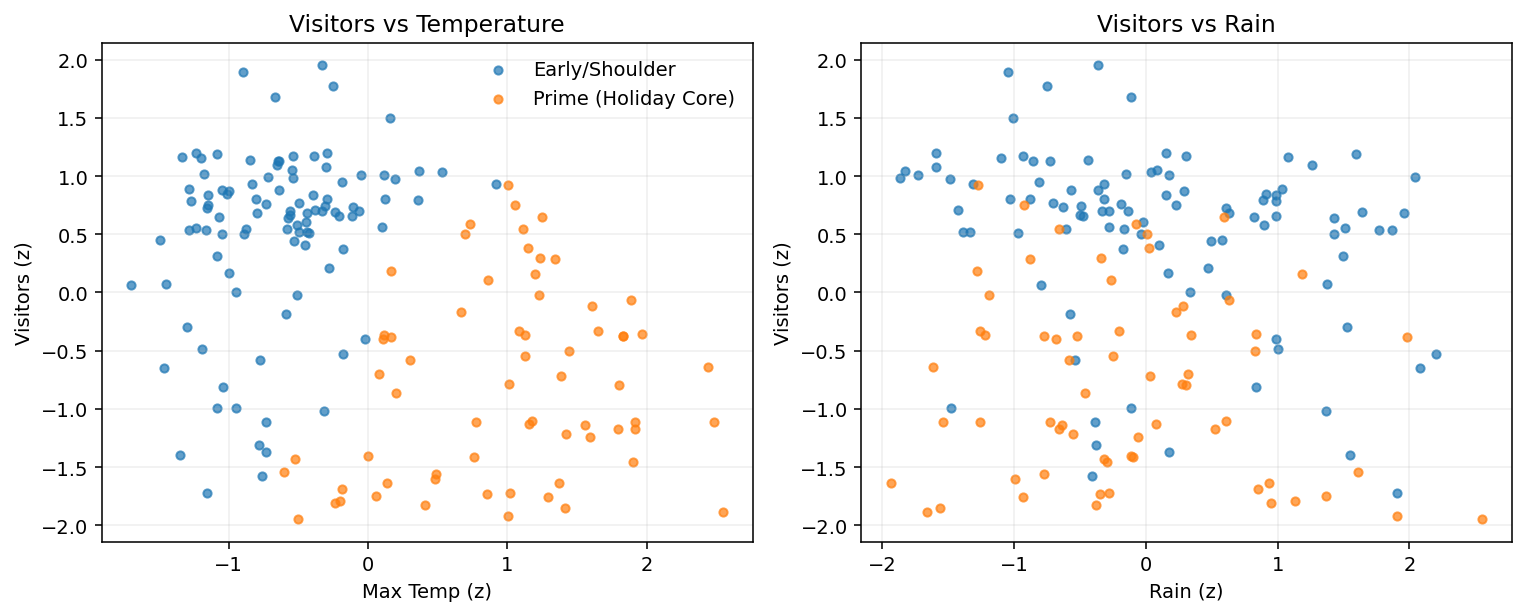

                      Weeks  MedianWeek  MeanVisitorsZ  MeanMaxTempZ  \
ClusterName                                                            
Early/Shoulder          100         7.0           0.51         -0.64   
Prime (Holiday Core)     65        12.0          -0.79          0.99   

                      MeanRainZ  
ClusterName                      
Early/Shoulder             0.09  
Prime (Holiday Core)      -0.14  


In [ ]:
# --- 0) Human-friendly cluster names (override if you prefer 2 buckets) ---
order = (centroids.assign(MeanWeek=feat_z.groupby("Cluster")["Week"].mean())
                     ["MeanWeek"].sort_values().index.tolist())
name_lookup = {c:n for c,n in zip(order, ["Early/Shoulder","Prime (Holiday Core)","Late"][:len(order)])}
feat_z["ClusterName"] = feat_z["Cluster"].map(name_lookup)

# --- 1) Model selection: elbow + silhouette ---
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler

inertias, sils = [], []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=140)
ax[0].plot(range(2,9), inertias, marker="o")
ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia"); ax[0].grid(alpha=.2)
ax[1].plot(range(2,9), sils, marker="o", color="#e63946")
ax[1].set_title("Silhouette"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Score"); ax[1].grid(alpha=.2)
plt.tight_layout(); plt.show()

# --- 2) Calendar heatmap: Year x Week (ordered by seasonal timing) ---
pivot = feat_z.pivot(index="Year", columns="Week", values="Cluster")
cmap = ListedColormap(["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"][:best_k])  # cool→warm progression
plt.figure(figsize=(10,5), dpi=140)
im = plt.imshow(pivot.values, aspect="auto", cmap=cmap, interpolation="nearest")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(pivot.shape[1]), pivot.columns)
plt.xlabel("Week of Season"); plt.ylabel("Year")
plt.title("Weekly Cluster Map (cool=early, warm=late)")
cbar = plt.colorbar(im, ticks=sorted(order))
cbar.ax.set_yticklabels([name_lookup[i] for i in sorted(order)])
plt.tight_layout(); plt.show()

# --- 3) Cluster profiles (z-score visitors) with band for 25–75% ---
q = (feat_z.groupby(["ClusterName","Week"])["Visitors_Total_sm"]
          .agg(["median", lambda s: s.quantile(.25), lambda s: s.quantile(.75)])
          .rename(columns={"<lambda_0>":"q25","<lambda_1>":"q75"})
          .reset_index())
fig, ax = plt.subplots(figsize=(10,4.5), dpi=140)
for cname, g in q.groupby("ClusterName"):
    ax.plot(g["Week"], g["median"], label=cname, lw=2)
    ax.fill_between(g["Week"], g["q25"], g["q75"], alpha=.15)
ax.axhline(0, color="#bbb", lw=1)
ax.set_title("Visitor Intensity by Cluster (median with IQR band)")
ax.set_xlabel("Week"); ax.set_ylabel("Visitors (z-score)"); ax.legend(frameon=False, ncol=2)
ax.grid(alpha=.2); plt.tight_layout(); plt.show()

# --- 4) Visitors vs Climate scatter (colored by cluster) ---
fig, ax = plt.subplots(1,2, figsize=(11,4.5), dpi=140)
for cname, g in feat_z.groupby("ClusterName"):
    ax[0].scatter(g["MaxTemp_C_sm"], g["Visitors_Total_sm"], s=18, alpha=.7, label=cname)
ax[0].set_xlabel("Max Temp (z)"); ax[0].set_ylabel("Visitors (z)")
ax[0].set_title("Visitors vs Temperature"); ax[0].grid(alpha=.2)
ax[0].legend(frameon=False)

for cname, g in feat_z.groupby("ClusterName"):
    ax[1].scatter(g["Rain_mm_sm"], g["Visitors_Total_sm"], s=18, alpha=.7, label=cname)
ax[1].set_xlabel("Rain (z)"); ax[1].set_ylabel("Visitors (z)")
ax[1].set_title("Visitors vs Rain"); ax[1].grid(alpha=.2)
plt.tight_layout(); plt.show()

# --- 5) Quick summary table for slides ---
summary = (feat_z.groupby("ClusterName")
           .agg(Weeks=("Week","count"),
                MedianWeek=("Week","median"),
                MeanVisitorsZ=("Visitors_Total_sm","mean"),
                MeanMaxTempZ=("MaxTemp_C_sm","mean"),
                MeanRainZ=("Rain_mm_sm","mean"))
           .sort_values("MedianWeek"))
print(summary.round(2))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- helper: find resort columns ----------
def get_resort_cols(df):
    base_cols = {"Year","Week"}
    return [c for c in df.columns if c not in base_cols and np.issubdtype(df[c].dtype, np.number)]

# ---------- main plot ----------
def plot_weekly_visitation(df, year, title_prefix="Weekly Visitation"):
    resorts = get_resort_cols(df)

    # data for the selected year
    d = (df[df["Year"]==year]
         .sort_values("Week")
         .reset_index(drop=True))
    if d.empty:
        raise ValueError(f"No rows for Year={year}")

    # totals per week (this year)
    d["TotalVisitors"] = d[resorts].sum(axis=1)

    # context band: min/max total across all years for each week
    totals_all = df.assign(Total=df[resorts].sum(axis=1))
    ctx = (totals_all
           .groupby("Week")["Total"]
           .agg(MinVisitors="min", MaxVisitors="max")
           .reindex(d["Week"]))  # align to plotted weeks

    # color palette (cool → warm)
    palette = [
        "#264653", "#2a9d8f", "#287271", "#8ab17d",
        "#bde0fe", "#a2d2ff", "#ffafcc", "#ff6b6b", "#e76f51"
    ]
    color_map = {res: palette[i % len(palette)] for i, res in enumerate(resorts)}

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8, 6), dpi=140)

    # context min–max ribbon
    ax.fill_between(d["Week"], ctx["MinVisitors"], ctx["MaxVisitors"],
                    color="#d00000", alpha=0.18, label="MaxVisitors")
    ax.fill_between(d["Week"], ctx["MinVisitors"], d["TotalVisitors"],
                    color="#9d0208", alpha=0.18, label="MinVisitors")

    # stacked area for resorts
    stacks = [d[c].values for c in resorts]
    ax.stackplot(d["Week"], stacks, labels=resorts,
                 colors=[color_map[c] for c in resorts], alpha=0.95)

    # aesthetics
    ax.set_title(f"{title_prefix} – {year}", fontsize=18, weight="bold", pad=10)
    ax.set_xlabel("Week of Year")
    ax.set_ylabel("Visitors")
    ax.set_xlim(d["Week"].min(), d["Week"].max())
    ax.grid(axis="y", alpha=0.25)

    # legend in a clean box at right
    leg = ax.legend(title="Resort", loc="center left",
                    bbox_to_anchor=(1.02, 0.5), frameon=True)
    leg.get_frame().set_alpha(0.9)

    plt.tight_layout()
    plt.show()

# ---------- usage ----------
# visit = pd.read_excel("Visitation_1.xlsx", sheet_name="Visitation")  # already loaded in your notebook
# plot_weekly_visitation(visit, 2022)   # change year as needed


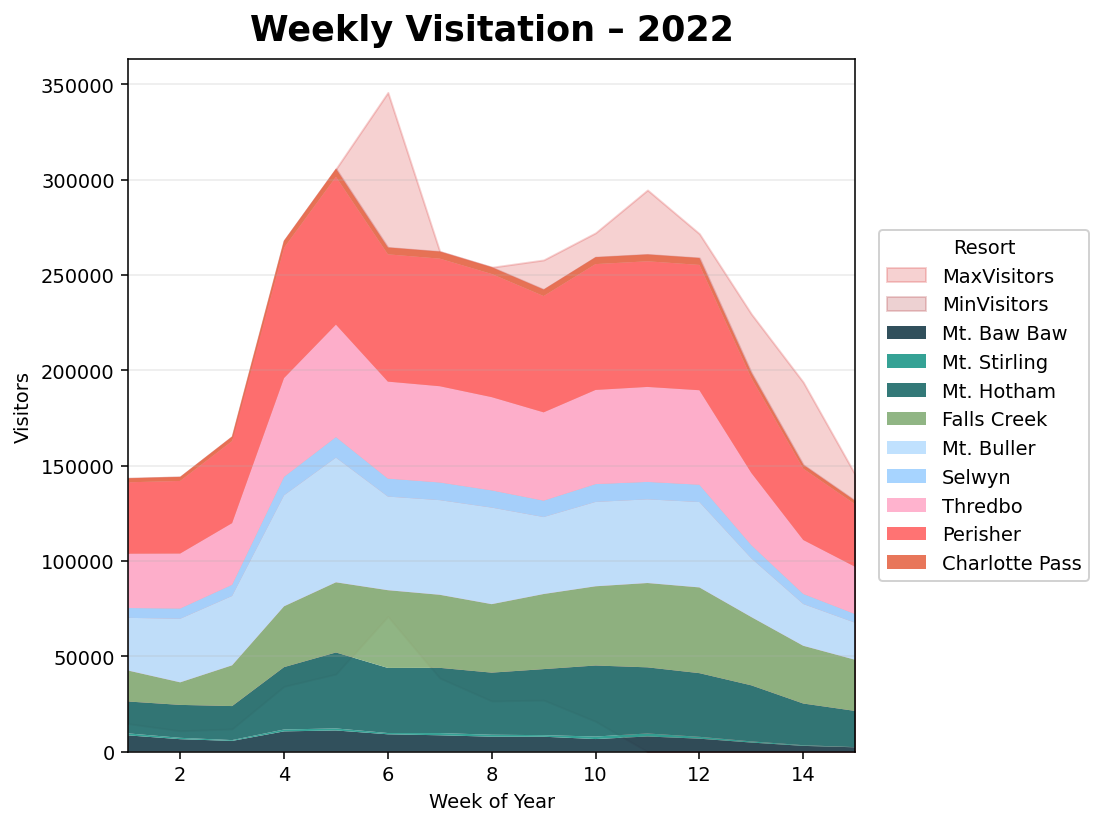

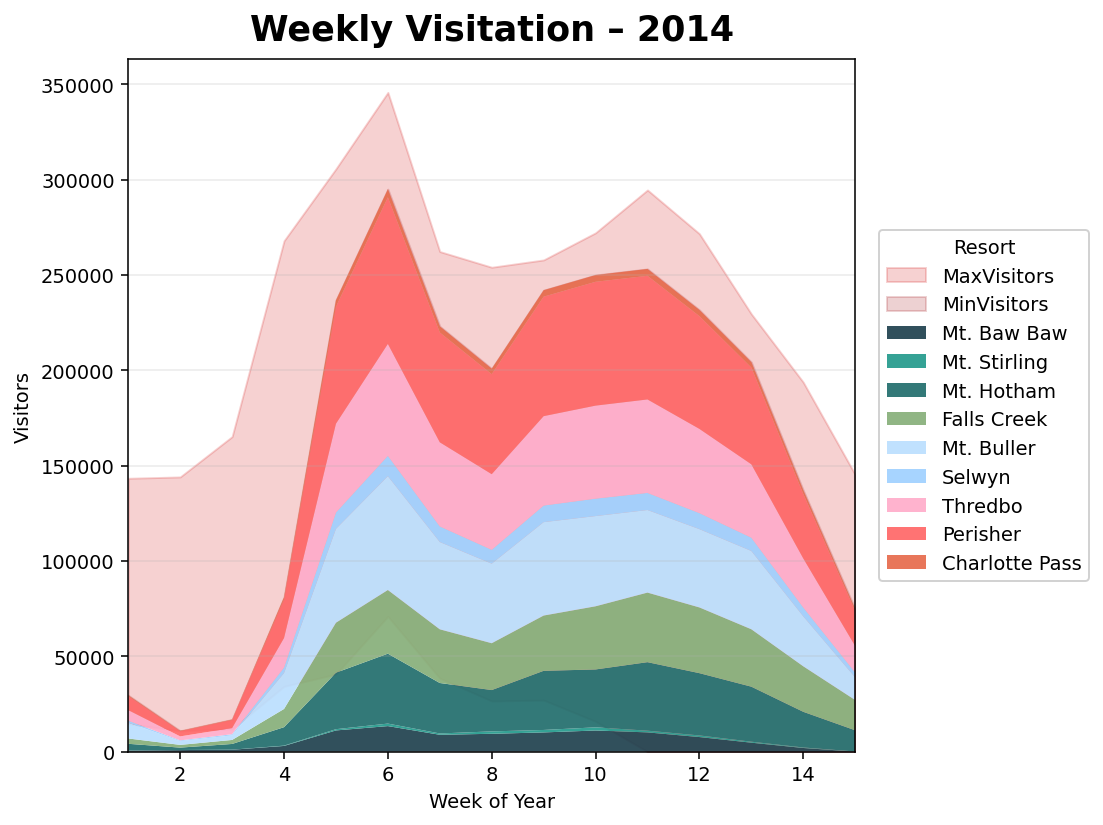

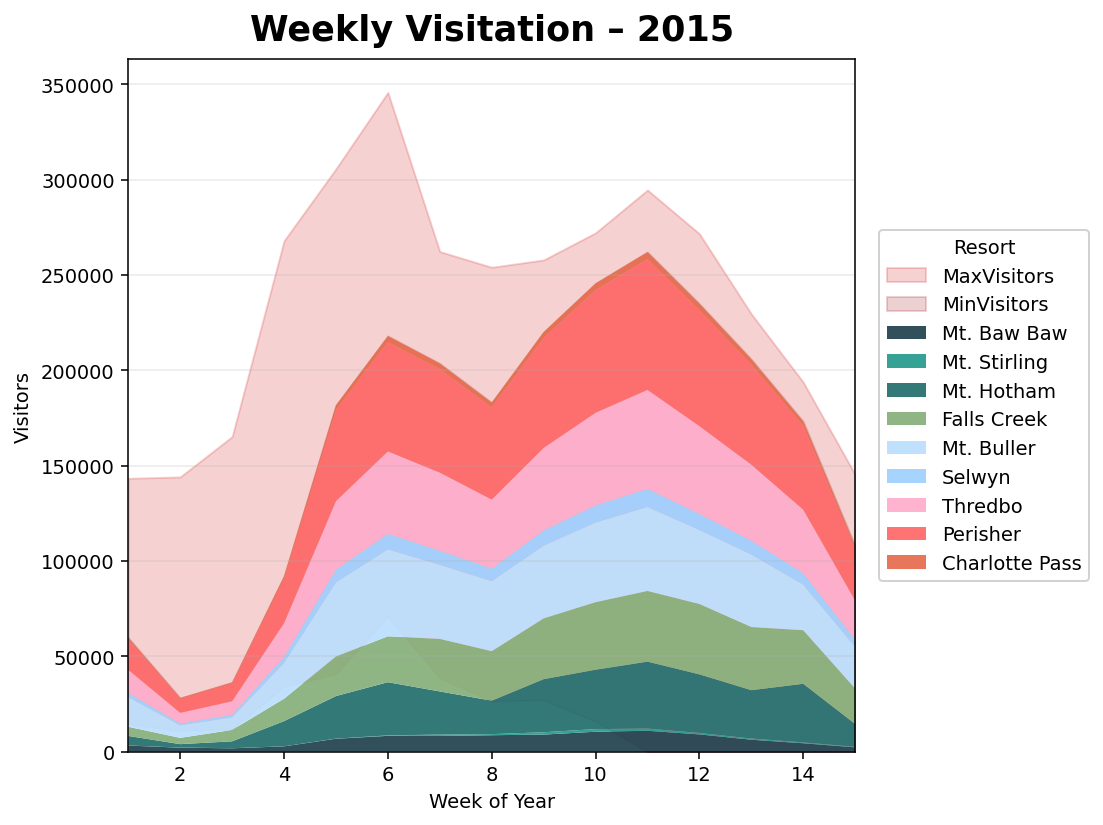

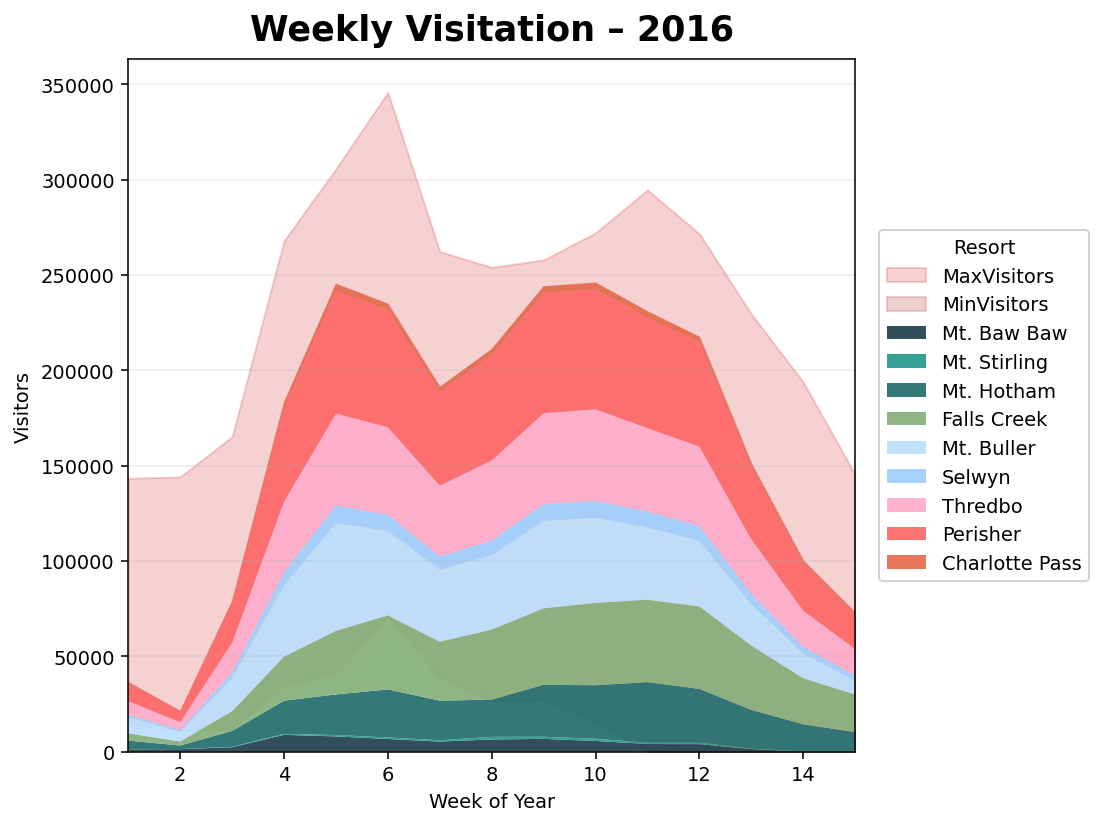

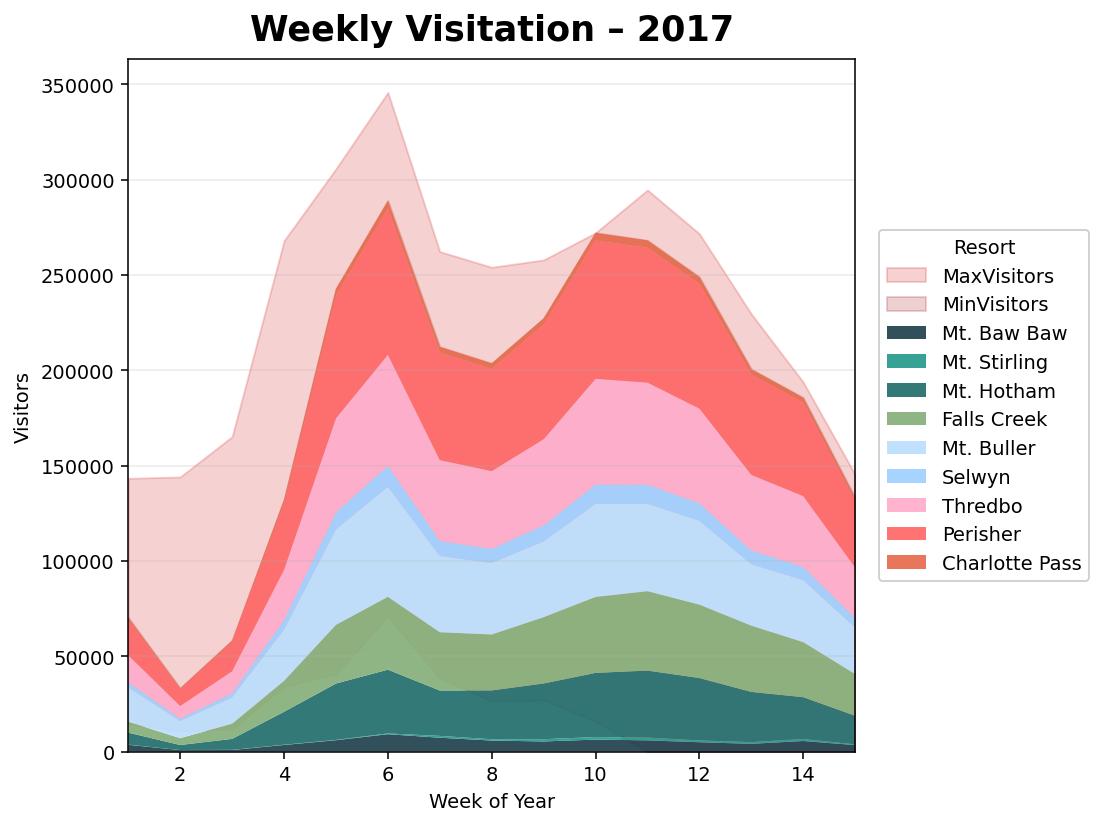

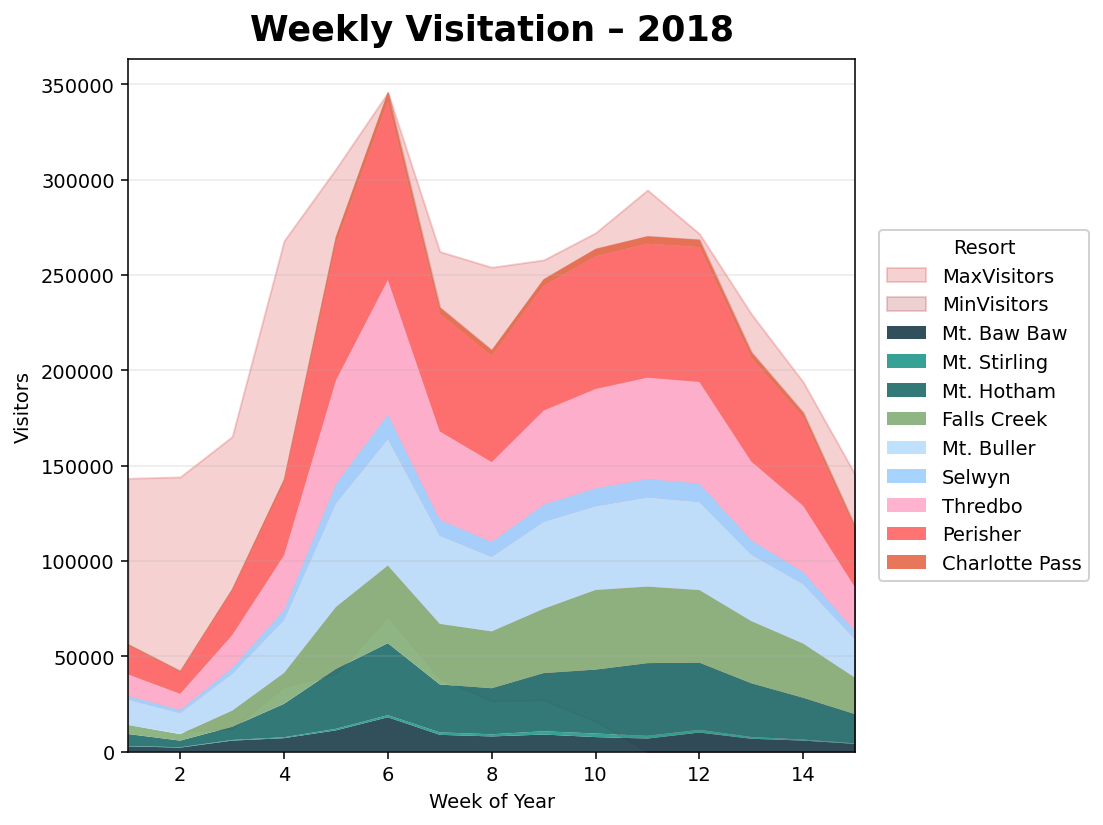

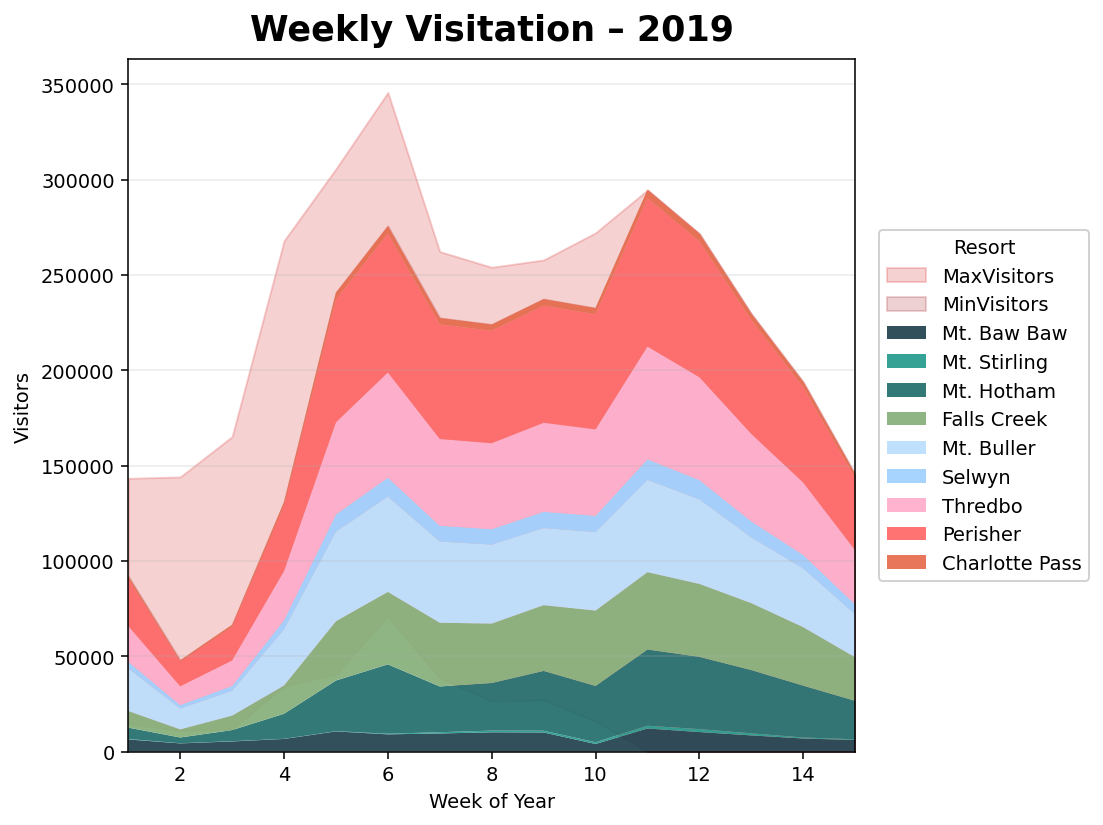

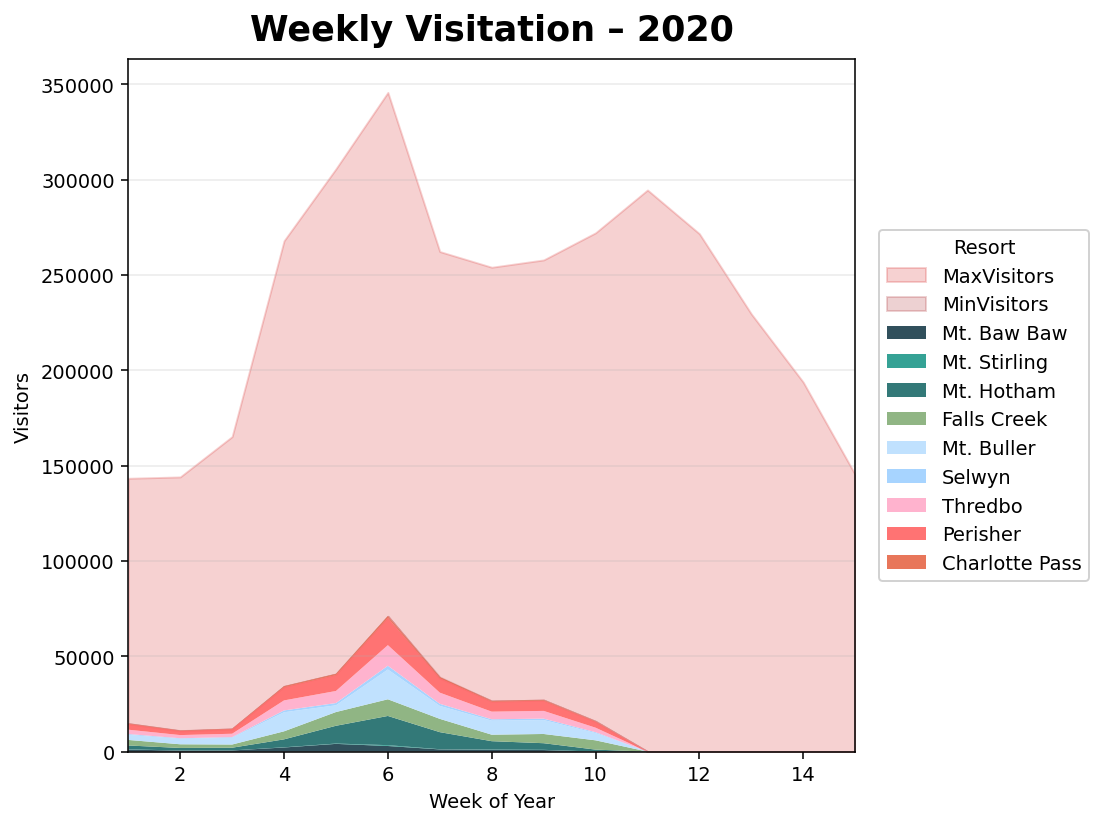

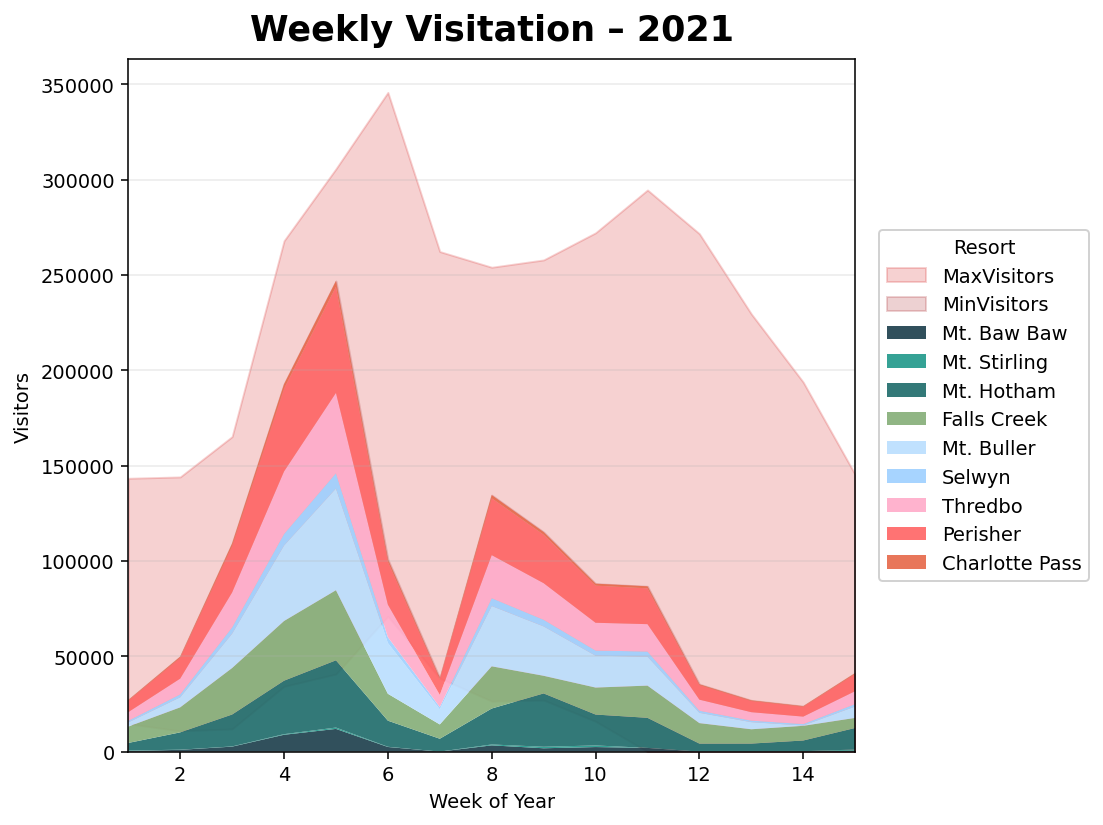

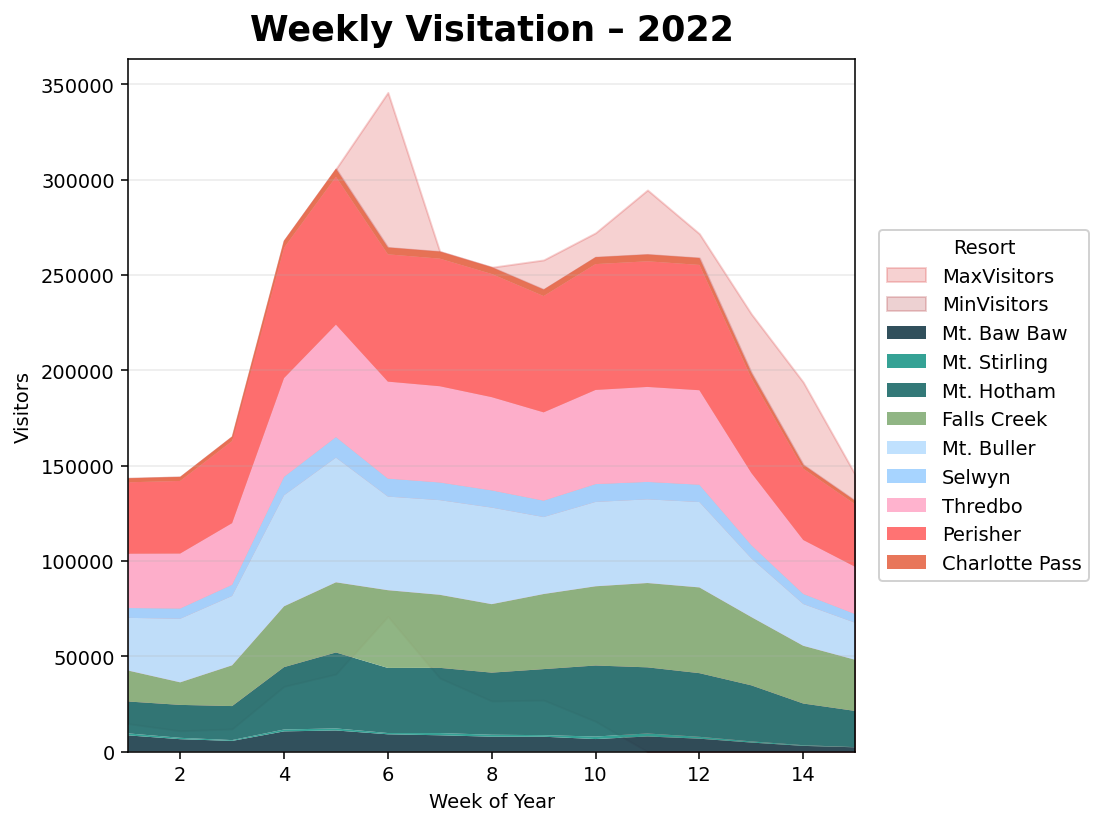

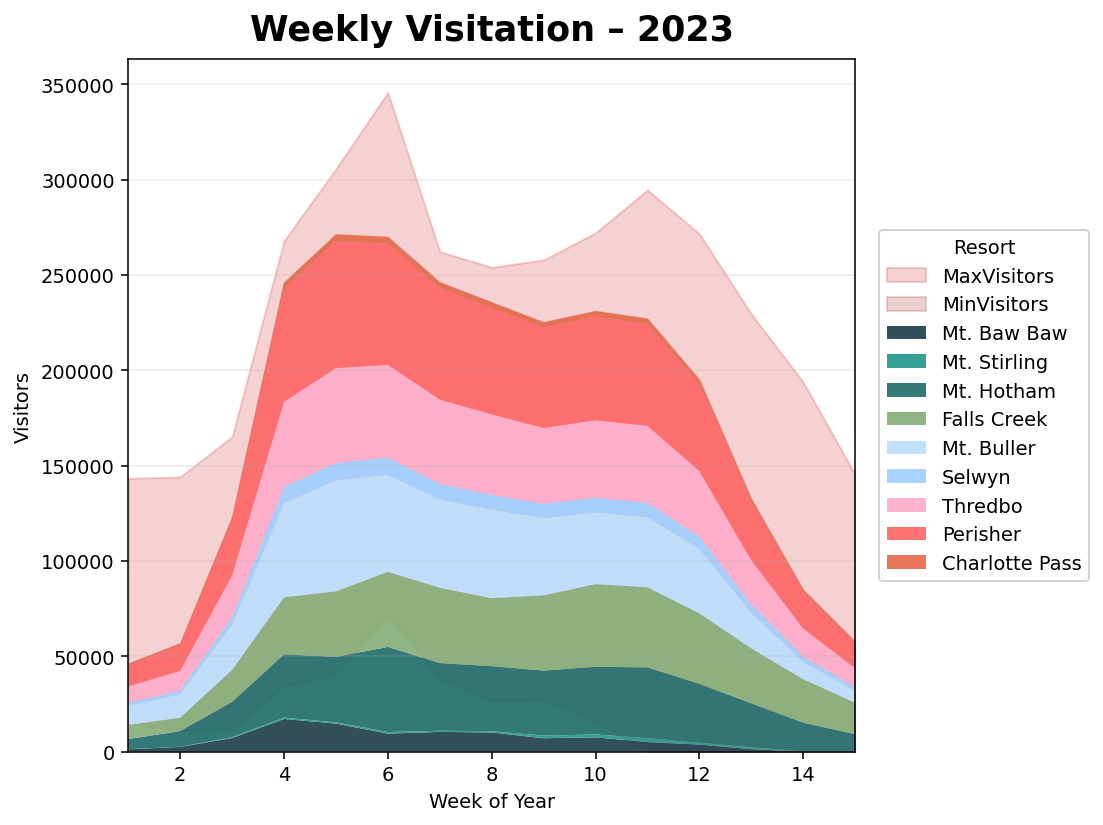

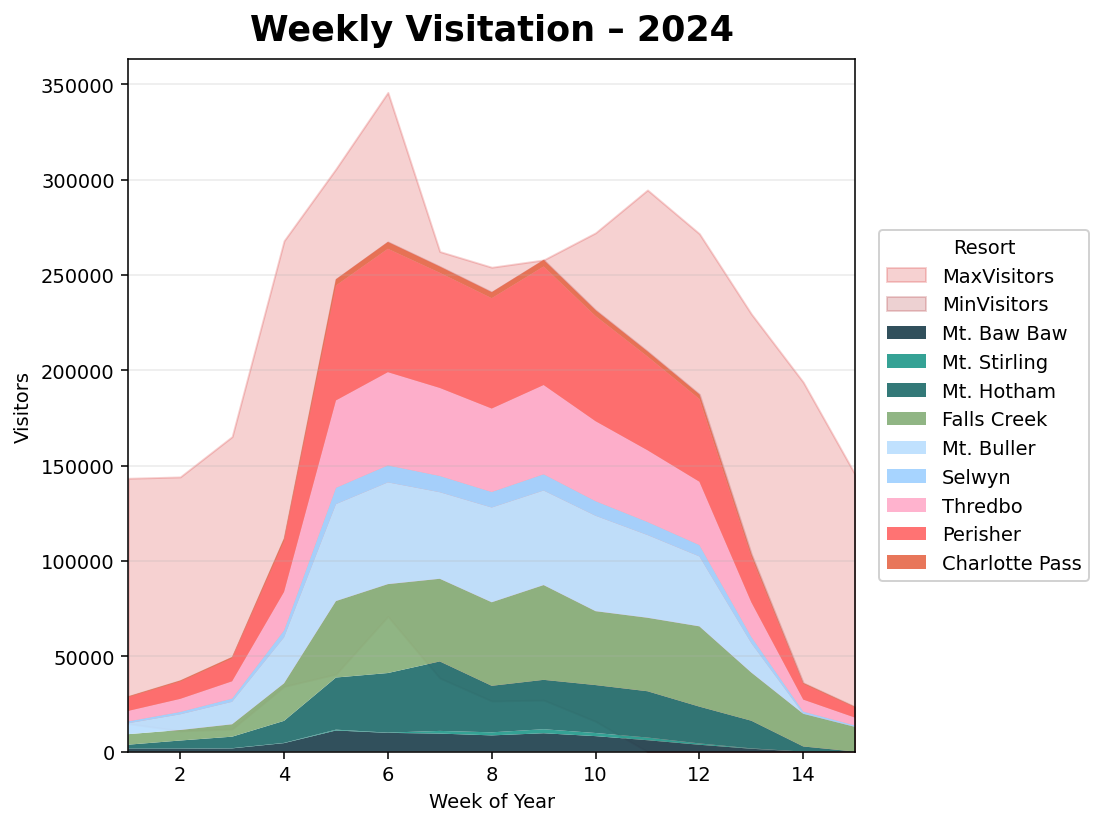

In [ ]:
import pandas as pd

# 1. Load your visitation sheet (the same file you showed me)
visit = pd.read_excel("Visitation_1.xlsx", sheet_name="Visitation")

# 2. Call the plotting function for a specific year
plot_weekly_visitation(visit, 2022)

# You can loop over multiple years if you want ALL charts:
for yr in sorted(visit["Year"].unique()):
    plot_weekly_visitation(visit, yr)


In [ ]:
visit = pd.read_excel("Visitation_1.xlsx", sheet_name="Visitation")